# Сети с радиальными базисными элементами





**Цель работы**: исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и аппроксимации функции.


| <!-- --> | <!-- --> |
|:---------|:---------|
| Студент    | Почечура А.А.   |
| Группа   | М8О-406Б-20  |
| Вариант    | 18   |

Подключаем библиотеки, которые нам понадобятся в данной работе

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split

### Этап 1

Создадим три тензора: тензор со значениями точек для первого эллипса, тензор со значениями точек для второго эллипса и тензор со значениями точек для параболы. Для получения точек будем использовать параметрическое уравнение эллипса (x = a * cos(phi),  y = b * sin(phi)) и параболы (y = (2 * p * x) ^ 0.5), добавив к ним значения смещений.

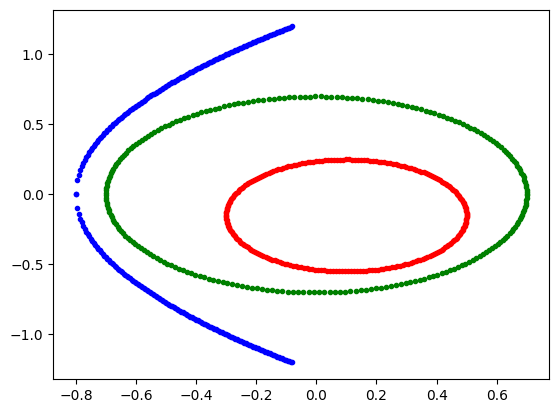

In [2]:
t = torch.arange(0, 2*torch.pi, 0.025)

a1 = 0.4
b1 = 0.4
alfa1 = 0
x01 = 0.1
y01 = -0.15

x_data1 = torch.Tensor([(torch.cos(phi+alfa1)*a1+x01,torch.sin(phi+alfa1)*b1+y01) for phi in t])

a2 = 0.7
b2 = 0.7
alfa2 = 0
x02 = 0
y02 = 0

x_data2 = torch.Tensor([(torch.cos(phi+alfa2)*a2+x02,torch.sin(phi+alfa2)*b2+y02) for phi in t])

t_3 = torch.arange(0, 0.8, 0.005)
p3 = 1
alfa3 = 0
x03 = -0.8
y03 = 0

y3_plus = [(x+x03, (2*p3*x)**0.5) for x in t_3 if (2*p3*x)**0.5<=1.2]
y3_minus = [(x+x03, -(2*p3*x)**0.5) for x in t_3 if (2*p3*x)**0.5<=1.2]
x_data3 = torch.Tensor(y3_plus+y3_minus)

plt.scatter(x_data1[:,0], x_data1[:,1], c="red", marker='.')
plt.scatter(x_data2[:,0], x_data2[:,1], c="green", marker='.')
plt.scatter(x_data3[:,0], x_data3[:,1], c="blue", marker='.')
plt.show()

Далее берём из каждого тензора соответственно 60, 100 и 120 случайных точек. Создадим массивы классов для каждой выборки: точка принадлежит первому множеству, если значения классов соответствуют значениям [1, 0, 0]. Аналогично для второго множества: [0, 1, 0]; и третьего множества: [0, 0, 1].

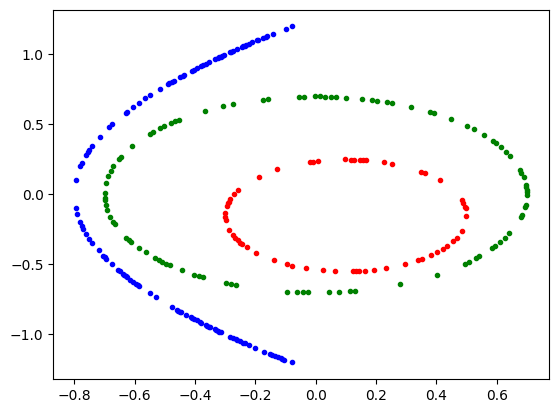

In [42]:
tmp = torch.randperm(x_data1.shape[0])
x_data1 = x_data1[tmp][:60,:]

one = torch.ones ((x_data1.shape[0],1))
zero = torch.zeros ((x_data1.shape[0],1))
y_data1 = torch.cat([one,zero,zero],dim=1)


tmp = torch.randperm(x_data2.shape[0])
x_data2 = x_data2[tmp][:100,:]

one = torch.ones ((x_data2.shape[0],1))
zero = torch.zeros ((x_data2.shape[0],1))
y_data2 = torch.cat([zero,one,zero],dim=1)


tmp = torch.randperm(x_data3.shape[0])
x_data3 = x_data3[tmp][:120,:]

one = torch.ones ((x_data3.shape[0],1))
zero = torch.zeros ((x_data3.shape[0],1))
y_data3 = torch.cat([zero,zero,one],dim=1)

plt.scatter(x_data1[:,0], x_data1[:,1], c="red", marker='.')
plt.scatter(x_data2[:,0], x_data2[:,1], c="green", marker='.')
plt.scatter(x_data3[:,0], x_data3[:,1], c="blue", marker='.')
plt.show()

Каждую выборку разделим на тестовую и тренировочную и объединим их в два тензора: x_train, x_test.

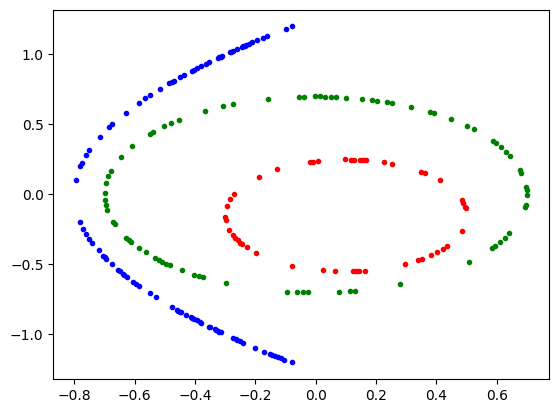

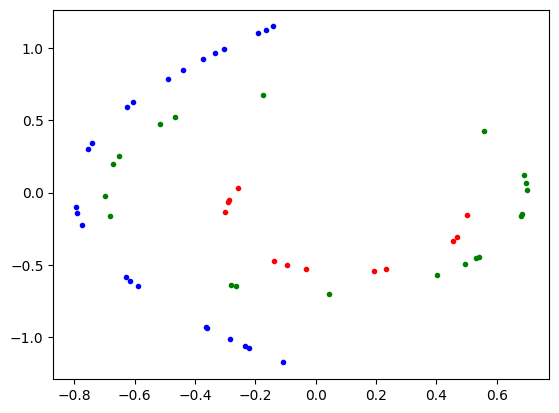

In [43]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_data1, y_data1, test_size=0.2)

x_train2, x_test2, y_train2, y_test2 = train_test_split(x_data2, y_data2, test_size=0.2)

x_train3, x_test3, y_train3, y_test3 = train_test_split(x_data3, y_data3, test_size=0.2)

x_train = torch.cat([x_train1,x_train2,x_train3],dim=0)
y_train = torch.cat([y_train1,y_train2,y_train3],dim=0)


x_test = torch.cat([x_test1,x_test2,x_test3],dim=0)
y_test = torch.cat([y_test1,y_test2,y_test3],dim=0)

tmp = torch.randperm(x_train.shape[0])
x_train = x_train[tmp]
y_train = y_train[tmp]


tmp = torch.randperm(x_test.shape[0])
x_test = x_test[tmp]
y_test = y_test[tmp]



plt.scatter(x_train1[:,0], x_train1[:,1], c="red", marker='.')
plt.scatter(x_train2[:,0], x_train2[:,1], c="green", marker='.')
plt.scatter(x_train3[:,0], x_train3[:,1], c="blue", marker='.')
plt.show()
plt.scatter(x_test1[:,0], x_test1[:,1], c="red", marker='.')
plt.scatter(x_test2[:,0], x_test2[:,1], c="green", marker='.')
plt.scatter(x_test3[:,0], x_test3[:,1], c="blue", marker='.')
plt.show()

Задаём параметры линейного слоя

In [5]:
class Linear(nn.Module):
  def __init__(self, inputs, outputs):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(inputs, outputs))
    self.bias = nn.Parameter(torch.randn(outputs))

  def forward(self, x):
    x = x @ self.weights + self.bias
    return x

Создадим класс RBF, с помощью которого опишем наш радиальный слой. В инициализации будут хранится преобразующие центры слоя и входные данные. В функции forward происходит гауссовское преобразование входных данных.

In [6]:
class RBF(nn.Module):
    def __init__(self, inputs, centers):
        super().__init__()
        self.num_centers = centers
        self.inputs = inputs

    def forward(self, x, SPREAD = 0.3):
        ans  = torch.zeros((x.shape[0], self.num_centers))
        for i in range(0, x.shape[0]):
          ans[i] = torch.exp(-(x[i]-self.centers).pow(2).sum(dim=2)/SPREAD/SPREAD)
        return ans


    def _initialize_centers(self, X):
        ind = torch.randperm(len(X))[:self.num_centers]
        self.centers = nn.Parameter(X[ind].view(1, self.num_centers, -1))
        self.beta = nn.Parameter(torch.ones(1,self.num_centers))

Класс RBFN описывает нашу сеть, состояющую из двух слоёв, целиком

In [7]:
class RBFN(nn.Module):
    def __init__(self, inputs, centers, outputs):
        super().__init__()
        self.hidden = RBF(inputs, centers)
        self.output = Linear(centers, outputs)

    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        return x

Далее идёт класс Trainer, с помощью которого мы тренируем нашу сеть. Иницализируем класс параметрами обучения и определяем порядок обучения.

In [8]:
class Trainer():
  def __init__(self,  net, loss_f, learning_rate=1e-3,
              epoch_amount=10,
              optim=torch.optim.Adam):

    self.loss_f = loss_f
    self.learning_rate = learning_rate
    self.epoch_amount = epoch_amount
    self.optim = optim
    self.model = net

    self.train_loss = []

  def predict(self, X):
    with torch.no_grad():
      return self.model(X)

  def fit(self, x_train, y_train):
    Net = self.model
    Net.hidden._initialize_centers(x_train)
    optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

    with tqdm(desc="epoch", total=self.epoch_amount) as bar:
      for epoch in range(self.epoch_amount):
        optimizer.zero_grad()
        predicted_values = Net(x_train)
        loss1 = self.loss_f(predicted_values, y_train)
        loss1.backward()
        optimizer.step()

        self.train_loss.append(loss1.detach().numpy())

        bar.set_postfix({"Loss_train": loss1.detach().numpy()})
        bar.update()

Производим обучение модели. Количество входных данных сети: 2 (x, y); количество выходных данных сети: 3 ([{0, 1},{0, 1},{0, 1}]).

In [48]:
net = RBFN(2,x_train.shape[0],3)
train = Trainer(net, nn.MSELoss(), 0.1, 100, torch.optim.Adam)
train.fit(x_train, y_train)

epoch: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s, Loss_train=0.0006520807]


Отобразим на графике значения ошибок, полученных в процессе обучения модели.

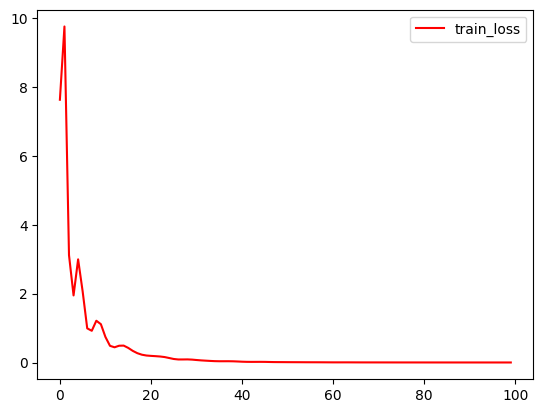

In [53]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.legend()
plt.show()

Среднее значение ошибки на тестовой выборке получилось следующим:

In [52]:
print("test_loss: ", train.loss_f(train.predict(x_test), y_test).numpy())

test_loss:  0.0017991161


Точки из тестовой выборки на графике

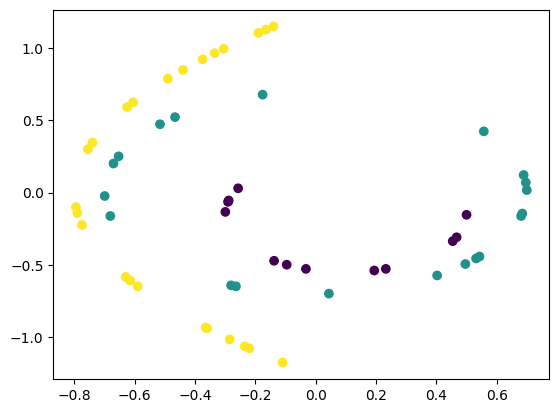

In [51]:
plt.scatter(x_test[:, 0], x_test[:, 1], c=torch.argmax(train.predict(x_test), axis=1))
plt.show()

Проиллюстрируем на графике полученное распределение точек на классы

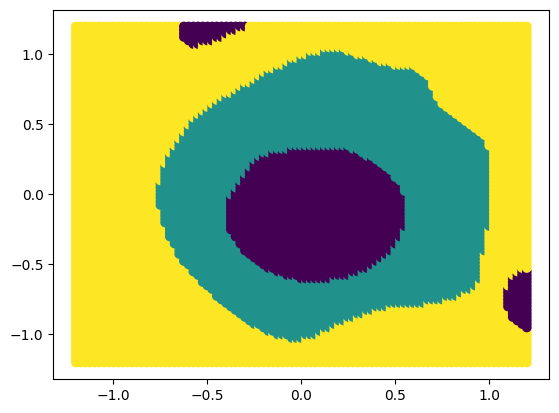

In [50]:
h = 0.025

xx = torch.Tensor([i for i in torch.arange(-1.2, 1.2 + h, h) for j in torch.arange(-1.2, 1.2 + h, h)])
yy = torch.Tensor([j for i in torch.arange(-1.2, 1.2 + h, h) for j in torch.arange(-1.2, 1.2 + h, h)])

predict = [torch.argmax(train.predict(torch.Tensor([xx[i], yy[i]]).view(1,-1)), axis=1) for i in range(xx.shape[0])]
plt.scatter(xx, yy, c=predict)
plt.show()

### Этап 2

Получим значения функции на заданном промежутке и разделим данные на тренировочную и валидационную. Отобразим полученные значения на графике.

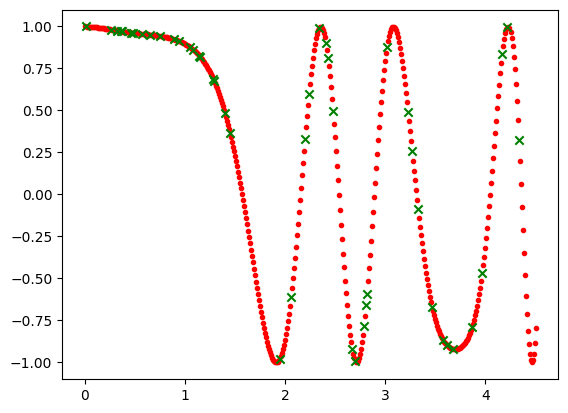

In [28]:
h = 0.01
x_data = torch.arange(0, 4.5+h, h).view(-1,1)
func = lambda t: torch.cos(torch.cos(t) * t * t - t)
y_data = torch.Tensor([func(a) for a in x_data]).view(-1,1)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)

plt.scatter(x_train, y_train, c="red", marker='.')
plt.scatter(x_val, y_val, c="green", marker='x')
plt.show()

Теперь реализуем сеть GRNN. Отличаться она будет только линенйным слоем, в котором будет происходит нормировка значений с помощью суммы по всем элементам.

In [37]:
class Linear1(nn.Module):
  def __init__(self, inputs, outputs):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(inputs, outputs))

  def forward(self, x):
    ans  = torch.zeros((x.shape[1], 1))
    for i in range(0, x.shape[0]):
      ans[i] = torch.div(x[i] @ self.weights, torch.sum(x[i]))
    return ans

Изменим значение SPREAD в RBF слое

In [34]:
class RBF1(nn.Module):
    def __init__(self, inputs, centers):
        super().__init__()
        self.num_centers = centers
        self.inputs = inputs

    def forward(self, x, SPREAD = 0.05):
        ans  = torch.zeros((x.shape[0], self.num_centers))
        for i in range(0, x.shape[0]):
          ans[i] = torch.exp(-(x[i]-self.centers).pow(2).sum(dim=2)/SPREAD/SPREAD)
        return ans


    def _initialize_centers(self, X):
        ind = torch.randperm(len(X))[:self.num_centers]
        self.centers = nn.Parameter(X[ind].view(1, self.num_centers, -1))
        self.beta = nn.Parameter(torch.ones(1,self.num_centers))

Класс GRNN описывает нашу сеть, состояющую из двух слоёв, целиком

In [35]:
class GRNN(nn.Module):
    def __init__(self, inputs, centers, outputs):
        super().__init__()
        self.hidden = RBF1(inputs, centers)
        self.output = Linear1(centers, outputs)

    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        return x

Обучим нашу модель, используя метод первого порядка

In [38]:
net = GRNN(1,x_train.shape[0],1)
train = Trainer(net, nn.MSELoss(), 0.1, 100, torch.optim.Adam)
train.fit(x_train, y_train)

epoch: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s, Loss_train=0.0002764767]


Отобразим полученные значения ошибок и предсказанные значения на графике

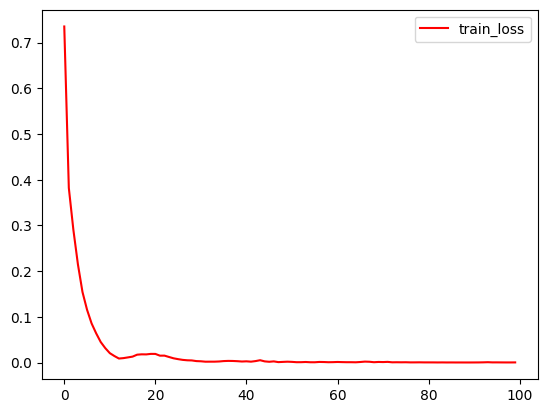

In [39]:
plt.plot(train.train_loss, "red", label='train_loss')
plt.legend()
plt.show()

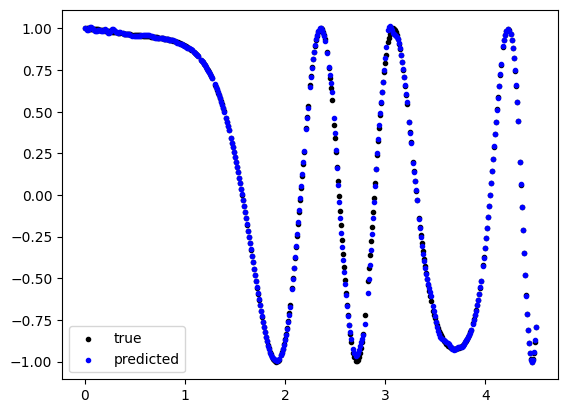

In [40]:
plt.scatter(x_train, y_train, c="black", label='true', marker='.')
plt.scatter(x_train, train.predict(x_train), c="blue", label='predicted', marker='.')
plt.legend()
plt.show()

**Вывод**: В процессе выполнения данной лабораторной работы я научился самостоятельно реализовывать и практически применять многослойные радиальные сети. Интересно было разбираться в тонкостях реализации данных сетей. Радилаьные сети учатся довольно быстро, однако они требует мноого памяти по сравнению с другими видами сетей.